In [1]:
import numpy as np
import pandas as pd
import os
import csv
import re
from dotenv import load_dotenv
import json
from openai import OpenAI
from urllib.parse import urlparse
import hashlib
import pdfkit
import requests
from playwright.sync_api import sync_playwright
from openai import OpenAI
import json
from bs4 import BeautifulSoup
from urllib.parse import quote_plus
from itertools import product
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
import time

In [2]:
path = '/home/cptaswadu/RESCUE-n8n/insurance'
load_dotenv(dotenv_path=os.path.join(path, ".env"))
openai_api_key = os.getenv("OPEN_AI_API_KEY")
perplexity_api_key = os.getenv("PERPLEXITY_API_KEY")
chatgpt_client = OpenAI(api_key=openai_api_key)

In [3]:
answer_policy_dir = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/policy_answer"
for filename in os.listdir(answer_policy_dir):
    file_path = os.path.join(answer_policy_dir, filename)
    if os.path.isfile(file_path):
        with open(file_path, "rb") as f:
            content = f.read()
            md5_hash = hashlib.md5(content).hexdigest()
        print(f"{filename} => {md5_hash}")

Aetna_Breast and Ovarian Cancer Susceptibility Gene Testing, Prophylactic Mastectomy, and Prophylactic Oophorectomy - Medical Clinical Policy Bulletins.pdf => 853350c3473bcef32091186fbb7318fd
Aetna_Genetic Testing - Medical Clinical Policy Bulletins.pdf => af9f1086001f5b00ec242195723c10bf
United Healthcare_genetic-testing-cardiac-disease.pdf => f77e783d8f23d96b1932bc0f7cf7e8c7
Cigna_MOL.TS_.306.C_Whole_Genome_Sequencing_Cigna_eff01.01.2025_pub09.10.2024.pdf => 36bb5264dda1b2027dcdfdd32a714204
Cigna_MOL.TS_.238.A_BRCA_Analysis_eff01.01.2025_pub09.10.2024_1.pdf => 626eac4d60df057ea93ece78f8cc3dfc
United Healthcare_genetic-testing-hereditary-cancer.pdf => c69485372670ce1d12aa8f61d83a06fd
United Healthcare_genetic-testing-neuromuscular-disorders.pdf => 4dec1a815b8ecffdf00d34ad7f04836f
CapitalBC_BRCA.pdf => 34dc0823a03ca2f20ba740345d7b57da
United Healthcare_whole-exome-and-whole-genome-sequencing.pdf => 4fadf6b3ca9d4d08131cb31365e3aa7d
Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.

In [4]:
def fuzzy_match(a, b, threshold=0.85):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio() >= threshold

In [5]:
def evaluate_md5_match(case_id, policy_path, ground_truth):
    with open(policy_path, "rb") as f:
        data = f.read()
    retrieved_md5 = hashlib.md5(data).hexdigest()
    expected_md5 = ground_truth.get(case_id, {}).get("expected_md5", "NOT_FOUND")
    match = (retrieved_md5 == expected_md5)
    print(f"Case ID: {case_id}, Retrieved MD5: {retrieved_md5}, Expected MD5: {expected_md5}, Match: {match}")
    return match, retrieved_md5, expected_md5


In [6]:
def load_inputs(case_ex_path, ground_truth_path):
    with open(case_ex_path, "r") as f:
        case_ex = json.load(f)

    with open(ground_truth_path, "r") as f:
        ground_truth = json.load(f)

    return case_ex, ground_truth

case_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/case_ex.json"
truth_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/ground_truth.json"

case_ex, ground_truth = load_inputs(case_path, truth_path)

In [7]:
def download_pdf(url, save_path):
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        with open(save_path, "wb") as f:
            f.write(response.content)
        print(f"✅ Downloaded PDF: {save_path}")
        return True
    except Exception as e:
        print(f"❌ Failed to download PDF from {url}: {e}")
        return False


def save_webpage_as_pdf(url, save_path):
    try:
        pdfkit.from_url(url, save_path)
        print(f"✅ Saved webpage as PDF: {save_path}")
        return True
    except Exception as e:
        print(f"❌ Failed to save {url} as PDF: {e}")
        return False

In [ ]:
def find_policy_url_with_web_search(patient_info_text, model="chatgpt", chatgpt_client=None, perplexity_api_key=None, max_retries=3, save_dir= None, case_id=None):
    os.makedirs(save_dir, exist_ok=True)

    prompt = f"""
You are a clinical insurance assistant.
Your task is to search for the most relevant and up-to-date official insurance policy document URL that addresses **genetic testing coverage** for the following patient. 
Take into account both the patient’s clinical condition and insurance plan.
Please focus on the insurance provider and the plan, genetic test, and the state where the patient resides based on the patient information.

PATIENT INFORMATION:
{patient_info_text}

Instructions:
- Please only return a direct link to the official insurance policy file. Do not include summaries. 
- Emphasize documents that discuss **medical necessity**, **clinical guidelines**, **prior authorization requirements**, and **coverage criteria**.
- Based on the patient information, find the insurance provider from insurance plan, and focus on the genetic testing that the patient requested.
- If no relevant policy is found, respond with: **"No policy found."**
- Output **only the URL**. Do not include explanations, summaries, or any additional content.
"""

    messages = [
        {"role": "system", "content": "You are a clinical insurance assistant."},
        {"role": "user", "content": prompt}
    ]

    def call_chatgpt():
        response = chatgpt_client.responses.create(
            model="gpt-4o",
            input=messages,
            tools=[{"type": "web_search_preview"}]
        )
        return response.output_text.strip()

    def call_perplexity():
        headers = {
            "Authorization": f"Bearer {perplexity_api_key}",
            "Content-Type": "application/json"
        }
        data = {
            "model": "sonar-pro",
            "messages": messages,
            "temperature": 0
        }
        url = "https://api.perplexity.ai/chat/completions"
        res = requests.post(url, headers=headers, json=data)
        if res.status_code == 200:
            return res.json()["choices"][0]["message"]["content"].strip()
        else:
            raise Exception(f"Perplexity error: {res.status_code} - {res.text}")

    for attempt in range(1, max_retries + 1):
        try:
            print(f"🔁 Attempt {attempt} ({model})...")
            result_text = call_perplexity() if model == "perplexity" else call_chatgpt()
            print("🔎 Raw result from LLM:\n", result_text)
            if not result_text.startswith("http"):
                return {"status": "no_url", "url": None, "saved_path": None}
            
            base_name = f"{case_id or int(time.time())}.pdf"
            save_path = os.path.join(save_dir, base_name)

            if result_text.endswith(".pdf"):
                success = download_pdf(result_text, save_path)
            else:
                success = save_webpage_as_pdf(result_text, save_path)

            if success:
                return {"status": "success", "url": result_text, "saved_path": save_path}
            else:
                return {"status": "download_failed", "url": result_text, "saved_path": None}

        except Exception as e:
            print(f"❌ Attempt {attempt} failed: {e}")

    return {"status": "exhausted", "url": None, "saved_path": None}

In [9]:
def clean_json_response(response_text):
    original = response_text.strip()

    # Step 0: Check for hallucinated greeting (Perplexity fallback)
    if "how can I assist you" in original.lower() or "insurance-related questions" in original.lower():
        raise ValueError("Perplexity returned generic assistant response instead of JSON.")

    # Step 1: Try direct parsing
    try:
        return json.loads(original)
    except json.JSONDecodeError:
        pass

    # Step 2: Remove code block wrappers
    cleaned = re.sub(r"^```(?:json)?\s*|\s*```$", "", original, flags=re.IGNORECASE).strip()
    try:
        return json.loads(cleaned)
    except json.JSONDecodeError:
        pass

    # Step 3: Try to extract the first {...} JSON-like block
    match = re.search(r"(\{[\s\S]*?\})", original)
    if match:
        try:
            return json.loads(match.group(1))
        except json.JSONDecodeError:
            pass

    raise ValueError("No valid JSON found in the response.")

In [10]:
def format_question_block(q, indent=2):
    indent_str = " " * indent
    question_line = f"{q['question']}"

    if q.get("options") == ["Free text answer"]:
        question_line += f"\n{indent_str}(Free text answer allowed.)"
    else:
        question_line += f"\n{indent_str}Options: {', '.join(q['options'])}"

        if "additional_if_yes" in q:
            question_line += f"\n{indent_str}  If 'Yes':"
            for item in q["additional_if_yes"]:
                if isinstance(item, str):
                    question_line += f"\n{indent_str}    - {item}"
                elif isinstance(item, dict):
                    question_line += f"\n{indent_str}    - {format_question_block(item, indent + 6)}"

        if "additional_if_no" in q:
            question_line += f"\n{indent_str}  If 'No':"
            for item in q["additional_if_no"]:
                if isinstance(item, str):
                    question_line += f"\n{indent_str}    - {item}"
                elif isinstance(item, dict):
                    question_line += f"\n{indent_str}    - {format_question_block(item, indent + 6)}"

    return question_line


def format_questions(questions_list):
    return "\n\n".join([
        f"{q['id']}. {format_question_block(q)}"
        for q in questions_list
    ])


In [11]:
def run_qna(
    case_id,
    patient_info_text,
    policy_url,
    questions_list,
    qna_model="chatgpt", 
    chatgpt_client=None,
    perplexity_api_key=None,
    search_model="chatgpt",
    match=None 
):
    def format_questions(questions):
        def format_block(q, indent=2):
            indent_str = " " * indent
            question_line = f"{q['question']}"
            if q.get("options") == ["Free text answer"]:
                question_line += f"\n{indent_str}(Free text answer allowed.)"
            else:
                question_line += f"\n{indent_str}Options: {', '.join(q['options'])}"
                if "additional_if_yes" in q:
                    question_line += f"\n{indent_str}  If 'Yes':"
                    for item in q["additional_if_yes"]:
                        question_line += f"\n{indent_str}    - {item}" if isinstance(item, str) else f"\n{indent_str}    - {format_block(item, indent + 6)}"
                if "additional_if_no" in q:
                    question_line += f"\n{indent_str}  If 'No':"
                    for item in q["additional_if_no"]:
                        question_line += f"\n{indent_str}    - {item}" if isinstance(item, str) else f"\n{indent_str}    - {format_block(item, indent + 6)}"
            return question_line

        return "\n\n".join([
            f"{q['id']}. {format_block(q)}"
            for q in questions
        ])

    def clean_json_response(response_text):
        original = response_text.strip()

        # Step 0: Check for hallucinated response
        if "how can I assist you" in original.lower() or "insurance-related questions" in original.lower():
            raise ValueError("Perplexity returned a generic response instead of JSON.")

        # Step 1: Direct parsing
        try:
            return json.loads(original)
        except json.JSONDecodeError:
            pass

        # Step 2: Remove markdown code fences
        cleaned = re.sub(r"^```(?:json)?\s*|\s*```$", "", original, flags=re.IGNORECASE).strip()
        try:
            return json.loads(cleaned)
        except json.JSONDecodeError:
            pass

        # Step 3: Extract first JSON block
        match = re.search(r"(\{[\s\S]*?\})", original)
        if match:
            try:
                return json.loads(match.group(1))
            except json.JSONDecodeError:
                pass

        raise ValueError("No valid JSON found in response.")

    questions_formatted = format_questions(questions_list)

    prompt = f"""
You are a clinical insurance assistant specializing in genetic testing coverage policies.

You will be given:
1. Patient clinical information 
2. The official policy document URL

Your task is to read and interpret the policy content at the provided URL,
and answer the following clinical coverage questions for the patient based strictly on that document and the patient's information.

Focus especially on factors such as:
- Age requirements
- Clinical guidelines
- Medical necessity
- Prior authorization criteria 
- Any other relevant rules related to genetic testing coverage for this patient.

Instructions:
- If the policy document clearly answers the question, follow its criteria.
- If the policy is unclear, cautiously use the patient’s clinical information to infer a reasonable answer.
- DO NOT rely on general knowledge or assumptions beyond the given document.
- Strictly follow question constraints:
    - Choose only from the provided options.
    - For free text questions, answer concisely and clearly.
    - If a question says "If Yes, ALSO select from ...", and you answer "Yes", you MUST also select follow-up items.
    - Same for "If No, ALSO select from ...".

No explanations, summaries, or additional text.
Just Answer to the questions.
==== PATIENT INFORMATION ====
{patient_info_text}

==== POLICY DOCUMENT URL ====
{policy_url}

==== QUESTIONS ====
{questions_formatted}

Output your answers in JSON format only.
"""

    messages = [
        {"role": "system", "content": "You are a clinical insurance assistant."},
        {"role": "user", "content": prompt}
    ]

    try:
        print(f"🧠 Running QnA ({qna_model})...")

        if qna_model == "chatgpt":
            response = chatgpt_client.responses.create(
                model="gpt-4o",
                input=messages,
                tools=[{"type": "web_search_preview"}]
            )
            result_content = response.output_text.strip()

        elif qna_model == "perplexity":
            headers = {
                "Authorization": f"Bearer {perplexity_api_key}",
                "Content-Type": "application/json"
            }
            data = {
                "model": "sonar-pro",
                "messages": messages,
                "temperature": 0
            }
            url = "https://api.perplexity.ai/chat/completions"
            res = requests.post(url, headers=headers, json=data)

            print("[📥 Raw Perplexity response (text)]:")
            print(res.text[:500])

            try:
                parsed = json.loads(res.text)
                result_content = parsed.get("choices", [{}])[0].get("message", {}).get("content", "").strip()
            except Exception as e:
                raise ValueError(f"❗ Perplexity response could not be parsed: {e}")

            if not result_content:
                raise ValueError("❗ Perplexity returned empty content.")

        else:
            raise ValueError("Unsupported QnA model")

        result_json = clean_json_response(result_content)

        final_result = {}
        for k, v in result_json.items():
            if k == "policy_url":
                continue
            if "_selection" in k or "_details" in k:
                base_key = k.replace("_selection", "").replace("_details", "")
                final_result[f"{base_key}_followup"] = [v] if isinstance(v, str) else v
            else:
                final_result[k] = v

        final_result["match"] = match

        result_dir = f"/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/{search_model}_{qna_model}"
        os.makedirs(result_dir, exist_ok=True)
        filename = os.path.join(result_dir, f"{case_id}_qna_result.json")

        with open(filename, "w") as f:
            json.dump(final_result, f, indent=2)

        print(f"✅ QnA result saved to {filename}")

    except Exception as e:
        print("❗ QnA failed:", e)
        final_result = {
            "error": str(e),
            "raw_content": result_content if 'result_content' in locals() else "No response"
        }

    return final_result


In [12]:
questions_file_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/Insurance_Genetic_Testing_QA.json"

with open(questions_file_path, "r") as f:
    questions_data = json.load(f)

questions_list = questions_data["questions"]

In [13]:
def run_all_model_combinations(case_ex, questions_list, chatgpt_client, perplexity_api_key):
    model_options = ["chatgpt", "perplexity"]
    combinations = list(product(model_options, repeat=2))

    for search_model, qna_model in combinations:
        print(f"\n🚀 Starting experiments for: {search_model}_{qna_model}\n")

        failed_cases = [] 

        for case in case_ex:
            case_id = case["id"]
            patient_info = case["patient_info"]

            print(f"\n=== Running for {case_id} ===")

            try:
                combo_folder = f"{search_model}_{qna_model}"
                save_dir = os.path.join("/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna", combo_folder)
                policy_result = find_policy_url_with_web_search(
                    patient_info_text=patient_info,
                    model=search_model,
                    chatgpt_client=chatgpt_client,
                    perplexity_api_key=perplexity_api_key,
                    case_id=case_id,
                    save_dir=save_dir
                )
                policy_url = policy_result["url"]
                saved_path = policy_result["saved_path"]
                if policy_result["status"] == "success" and saved_path:
                    match, retrieved_md5, expected_md5 = evaluate_md5_match(case_id, saved_path, ground_truth)
                else:
                    match, retrieved_md5, expected_md5 = False, None, None

                run_qna(
                    case_id=case_id,
                    patient_info_text=patient_info,
                    policy_url=policy_url,
                    questions_list=questions_list,
                    qna_model=qna_model,
                    chatgpt_client=chatgpt_client,  
                    perplexity_api_key=perplexity_api_key,
                    search_model=search_model,
                    match=match
                )

            except Exception as e:
                print(f"❌ Failed on {case_id} ({search_model}_{qna_model}): {e}")
                failed_cases.append({
                    "case_id": case_id,
                    "search_model": search_model,
                    "qna_model": qna_model,
                    "error": str(e)
                })

        if failed_cases:
            fail_log_path = os.path.join("/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna", "Evaluation", "failed_cases.csv")
            os.makedirs(os.path.dirname(fail_log_path), exist_ok=True)
            pd.DataFrame(failed_cases).to_csv(fail_log_path, index=False)
            print(f"🚨 Logged failed cases to: {fail_log_path}")

run_all_model_combinations(
    case_ex=case_ex,
    questions_list=questions_list,
    chatgpt_client=chatgpt_client,  
    perplexity_api_key=perplexity_api_key
)



🚀 Starting experiments for: chatgpt_chatgpt


=== Running for Case1 ===
🔁 Attempt 1 (chatgpt)...


🔎 Raw result from LLM:
 https://www.uhcprovider.com/content/dam/provider/docs/public/policies/comm-medical-drug/genetic-testing.pdf
✅ Downloaded PDF: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_chatgpt/Case1.pdf
Case ID: Case1, Retrieved MD5: 7e2802c9d2b70cf1708a4cc060c07ba4, Expected MD5: 4fadf6b3ca9d4d08131cb31365e3aa7d, Match: False
🧠 Running QnA (chatgpt)...
✅ QnA result saved to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_chatgpt/Case1_qna_result.json

=== Running for Case2 ===
🔁 Attempt 1 (chatgpt)...
🔎 Raw result from LLM:
 https://www.aetna.com/cpb/medical/data/100_199/0140.html
✅ Saved webpage as PDF: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_chatgpt/Case2.pdf
Case ID: Case2, Retrieved MD5: 6d076bb7df3856eade9bed751d4a3b61, Expected MD5: af9f1086001f5b00ec242195723c10bf, Match: False
🧠 Running QnA (chatgpt)...
✅ QnA result saved to /home/cptaswadu/RESCUE-n8n/i

In [14]:
def merge_qna_jsons_to_csv(folder_path, output_csv_path):
    all_data = []

    for file in os.listdir(folder_path):
        if file.endswith("_qna_result.json"):
            case_id = file.replace("_qna_result.json", "")
            json_path = os.path.join(folder_path, file)

            with open(json_path, "r") as f:
                try:
                    result = json.load(f)
                    flat_result = {"case_id": case_id}

                    for k, v in result.items():
                        if isinstance(v, list):
                            flat_result[k] = "; ".join(map(str, v))
                        else:
                            flat_result[k] = v

                    all_data.append(flat_result)
                except Exception as e:
                    print(f"❗ Failed to parse {file}: {e}")

    if all_data:
        df = pd.DataFrame(all_data)
        df.to_csv(output_csv_path, index=False)
        print(f"✅ Merged CSV saved to: {output_csv_path}")
    else:
        print(f"⚠️ No valid QnA result files found in: {folder_path}")

def merge_all_combinations_to_csv(base_dir):
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            output_csv = os.path.join(base_dir, f"{folder_name}.csv")
            merge_qna_jsons_to_csv(folder_path, output_csv)


merge_all_combinations_to_csv(
    base_dir="/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna"
)

✅ Merged CSV saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_perplexity.csv
⚠️ No valid QnA result files found in: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/Evaluation
✅ Merged CSV saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_chatgpt.csv
✅ Merged CSV saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/perplexity_chatgpt.csv
✅ Merged CSV saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/perplexity_perplexity.csv


In [15]:
def load_converted_results_from_folder(folder_path):
    converted_results = {}
    for file in os.listdir(folder_path):
        if file.endswith("_qna_result.json"):
            case_id = file.replace("_qna_result.json", "")
            file_path = os.path.join(folder_path, file)
            with open(file_path, "r") as f:
                try:
                    data = json.load(f)
                except json.JSONDecodeError as e:
                    print(f"❗ JSON decode error in {file}: {e}")
                    continue

                clean = {}
                for k, v in data.items():
                    if k.endswith("_followup"):
                        clean[k] = v if isinstance(v, list) else [v]
                    else:
                        clean[k] = v

                converted_results[case_id] = clean
    return converted_results

In [16]:
def evaluate_qna_result(case_id, predicted_result, gold_result, folder_path=None):
    records = []
    correct_count = 0
    total_count = 0

    for qid in gold_result:
        if not qid.startswith("Q") or qid in {"policy_url", "Q17", "match", "expected_md5"} or "_followup" in qid:
            continue

        pred_answer = predicted_result.get(qid, "")
        gold_answer = gold_result.get(qid, "")

        if isinstance(pred_answer, list):
            pred_answer = ", ".join(pred_answer)
        if isinstance(gold_answer, list):
            gold_answer = ", ".join(gold_answer)

        pred_answer = pred_answer.strip()
        gold_answer = gold_answer.strip()

        if qid == "Q0":
            is_correct = fuzzy_match(pred_answer, gold_answer)
        else:
            is_correct = pred_answer == gold_answer

        score = 1 if is_correct else 0

        records.append({
            "Case": case_id,
            "Question": qid,
            "Predicted": pred_answer,
            "Gold": gold_answer,
            "Score": score
        })

        total_count += 1
        correct_count += score

        followup_key = qid + "_followup"
        pred_followup = predicted_result.get(followup_key, None)
        gold_followup = gold_result.get(followup_key, None)

        if is_correct and gold_followup is not None:
            def normalize(ans):
                if ans is None:
                    return "None"
                if isinstance(ans, list):
                    return ", ".join([a if isinstance(a, str) else a.get("answer", str(a)) for a in ans])
                return ans if isinstance(ans, str) else str(ans)

            pred_followup_norm = normalize(pred_followup)
            gold_followup_norm = normalize(gold_followup)

            pred_set = set(pred_followup_norm.split(", "))
            gold_set = set(gold_followup_norm.split(", ")) 

            followup_score = 1 if pred_set & gold_set else 0

            records.append({
                "Case": case_id,
                "Question": followup_key,
                "Predicted": pred_followup_norm,
                "Gold": gold_followup_norm,
                "Score": followup_score
            })

            total_count += 1
            correct_count += followup_score

    accuracy = correct_count / total_count * 100 if total_count > 0 else 0

    records.append({
        "Case": case_id,
        "Question": "TOTAL",
        "Predicted": f"Correct: {correct_count}",
        "Gold": f"Incorrect: {total_count - correct_count}",
        "Score": f"Accuracy: {accuracy:.2f}%"
    })

    df = pd.DataFrame(records)

    if folder_path:
        os.makedirs(folder_path, exist_ok=True)
        csv_path = os.path.join(folder_path, f"evaluation_{case_id}.csv")
        df.to_csv(csv_path, index=False)
        print(f"📄 Saved evaluation to {csv_path}")

    return df, accuracy

In [17]:
def evaluate_all_folders_with_summary(base_dir, gold_answers, summary_output_csv):
    eval_output_dir = os.path.join(base_dir, "Evaluation")
    os.makedirs(eval_output_dir, exist_ok=True)

    summary_records = []
    case_level_records = []

    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path) or folder_name == "Evaluation":
            continue

        print(f"\n📊 Evaluating folder: {folder_name}")

        try:
            retrieval_model, qna_model = folder_name.split("_")
        except ValueError:
            print(f"⚠️ Skipping invalid folder name format: {folder_name}")
            continue

        converted_results = load_converted_results_from_folder(folder_path)
        all_dfs = []
        accuracies = []

        for case_id, pred_result in converted_results.items():
            gold_result = gold_answers.get(case_id)
            if gold_result is None:
                continue

            match = pred_result.get("match", None)

            df_case, acc = evaluate_qna_result(
                case_id, pred_result, gold_result,
                folder_path=os.path.join(folder_path, "ETE_Evaluation")
            )
            all_dfs.append(df_case)
            accuracies.append(acc)

            case_level_records.append({
                "retrieval_model": retrieval_model,
                "qna_model": qna_model,
                "case_id": case_id,
                "accuracy": acc,
                "match": match
            })

        if all_dfs:
            merged_df = pd.concat(all_dfs, ignore_index=True)
            eval_csv_path = os.path.join(folder_path, "ETE_evaluation_results.csv")
            merged_df.to_csv(eval_csv_path, index=False)
            print(f"✅ Saved: {eval_csv_path}")

            summary_records.append({
                "retrieval_model": retrieval_model,
                "qna_model": qna_model,
                "mean_accuracy": sum(accuracies) / len(accuracies),
                "case_count": len(accuracies)
            })

    if summary_records:
        summary_df = pd.DataFrame(summary_records)
        summary_df.to_csv(summary_output_csv, index=False)
        print(f"\n✅ Summary saved to: {summary_output_csv}")
        print(summary_df)

    if case_level_records:
        df_case_level = pd.DataFrame(case_level_records)
        df_case_level["match"] = df_case_level["match"].fillna(False)
        df_case_level["combo"] = df_case_level["retrieval_model"] + "_" + df_case_level["qna_model"]

        case_csv_path = os.path.join(eval_output_dir, "ETE_case_level_accuracy.csv")
        df_case_level.to_csv(case_csv_path, index=False)
        print(f"✅ Case-level accuracy saved to: {case_csv_path}")

        # Match-based summary
        match_1 = df_case_level[df_case_level["match"] == True]["accuracy"]
        match_0 = df_case_level[df_case_level["match"] == False]["accuracy"]

        grouped_summary = pd.DataFrame([
            {"match_group": 1, "mean_accuracy": match_1.mean(), "count": len(match_1)},
            {"match_group": 0, "mean_accuracy": match_0.mean(), "count": len(match_0)},
            {"match_group": "all", "mean_accuracy": df_case_level["accuracy"].mean(), "count": len(df_case_level)}
        ])
        grouped_summary_path = os.path.join(eval_output_dir, "ETE_matched_accuracy.csv")
        grouped_summary.to_csv(grouped_summary_path, index=False)
        print(f"📊 Match-based grouped accuracy saved to: {grouped_summary_path}")

        overall_summary_path = os.path.join(eval_output_dir, "ETE_overall_accuracy.csv")
        pd.DataFrame([{
            "mean_accuracy_all_cases": df_case_level["accuracy"].mean(),
            "std_accuracy_all_cases": df_case_level["accuracy"].std(),
            "min_accuracy_all_cases": df_case_level["accuracy"].min(),
            "max_accuracy_all_cases": df_case_level["accuracy"].max(),
            "total_cases": len(df_case_level)
        }]).to_csv(overall_summary_path, index=False)
        print(f"📊 Overall accuracy saved to: {overall_summary_path}")

        # Heatmap
        pivot = df_case_level.groupby(["retrieval_model", "qna_model"])["accuracy"].mean().unstack()
        plt.figure(figsize=(6, 5))
        sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "Accuracy (%)"}, linewidths=0.5, linecolor="gray")
        #plt.title("Model Combination Accuracy Heatmap (50 Cases)")
        plt.ylabel("Retrieval LLM")
        plt.xlabel("QnA LLM")
        plt.tight_layout()
        heatmap_path = os.path.join(eval_output_dir, "ETE_accuracy_heatmap.png")
        plt.savefig(heatmap_path)
        print(f"📊 Heatmap saved to: {heatmap_path}")
        plt.show()
        plt.close()

        # Bar chart (overall)
        grouped = df_case_level.groupby("combo")["accuracy"].agg(["mean", "std"]).reset_index()
        plt.figure(figsize=(8, 5))
        plt.bar(grouped["combo"], grouped["mean"], yerr=grouped["std"], capsize=5)
        plt.ylabel("Accuracy (%)")
        plt.title("Accuracy by Model Combination (50 Cases)")
        plt.xticks(rotation=30)
        plt.tight_layout()
        bar_path = os.path.join(eval_output_dir, "ETE_accuracy_bar_chart.png")
        plt.savefig(bar_path)
        print(f"📊 Bar chart saved to: {bar_path}")
        plt.show()
        plt.close()

        # Bar chart (Matched vs Mismatched)
        grouped_match = df_case_level.groupby(["combo", "match"])["accuracy"].agg(["mean", "std"]).reset_index()
        pivot = grouped_match.pivot(index="combo", columns="match", values="mean").fillna(0)
        std_pivot = grouped_match.pivot(index="combo", columns="match", values="std").fillna(0)

        combos = pivot.index.tolist()
        x = np.arange(len(combos))
        width = 0.35

        plt.figure(figsize=(10, 6))
        plt.bar(x - width/2, pivot[True], width, yerr=std_pivot[True], label="Matched (True)", capsize=5)
        plt.bar(x + width/2, pivot[False], width, yerr=std_pivot[False], label="Mismatched (False)", capsize=5)
        plt.ylabel("Accuracy (%)")
        plt.title("Accuracy by Model Combination (Matched vs Mismatched)")
        plt.xticks(x, combos, rotation=30)
        plt.legend()
        plt.tight_layout()
        combo_match_path = os.path.join(eval_output_dir, "ETE_accuracy_bar_match_comparison.png")
        plt.savefig(combo_match_path)
        print(f"📊 Combined match comparison bar chart saved to: {combo_match_path}")
        plt.show()
        plt.close()



📊 Evaluating folder: chatgpt_perplexity
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_perplexity/ETE_Evaluation/evaluation_Case10.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_perplexity/ETE_Evaluation/evaluation_Case7.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_perplexity/ETE_Evaluation/evaluation_Case44.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_perplexity/ETE_Evaluation/evaluation_Case23.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_perplexity/ETE_Evaluation/evaluation_Case25.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/chatgpt_perplexity/ETE_Evaluation/evaluation_Case33.csv
📄 Saved evaluation to /home/cptaswadu/RESC

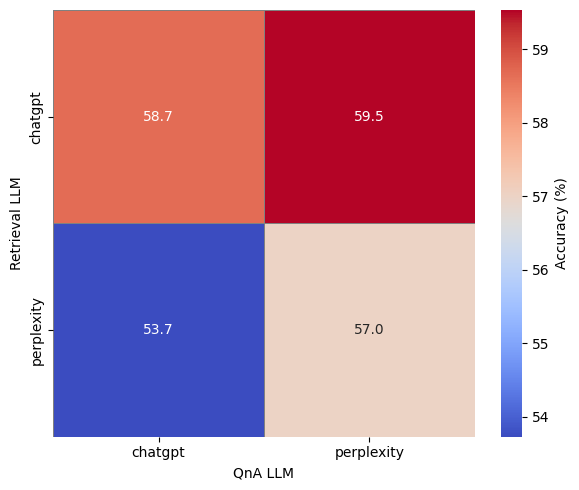

📊 Bar chart saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna/Evaluation/ETE_accuracy_bar_chart.png


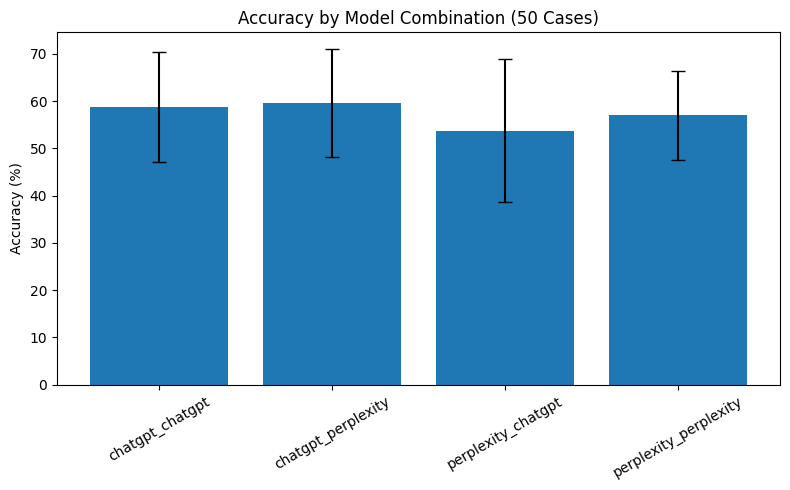

KeyError: True

<Figure size 1000x600 with 0 Axes>

In [18]:
base_dir = "/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/End-To-End/search_qna"
summary_output_csv = os.path.join(base_dir, "Evaluation", "summary_accuracy.csv")


evaluate_all_folders_with_summary(
    base_dir=base_dir,
    gold_answers=ground_truth,
    summary_output_csv=summary_output_csv
)
